# NIRCam Imaging Depth vs. Background

Here we calculate depths (5-sigma) for NIRCam imaging observations given your filters and exposure specifications. We show how these depths would vary if observations are performed on dates with minimum and maximum backgrounds given the coordinates (RA, Dec) of your target.

If these variations are concerning, APT offers an option (Special Requirement) to restrict the observations to dates with relatively low backgrounds. Should you set this Special Requirement? JDox recommends you require backgrounds to be within 10% of the minimum if your SNR would vary by more than 5% when observed at "low" background (10th percentile) vs. "high" background (90th percentile):

https://jwst-docs.stsci.edu/jwst-observatory-functionality/jwst-background-model/background-limited-observations

Here we do those calculations given your observations, target coordinates, and the magnitude of the source you're interested in.

In general, for NIRCam imaging in wide filters, the SNR will vary by more than 5% for faint objects (mag > 26). The backgrounds (and thus SNR) vary more for redder filters.

If you do set the Special Requirement, then APT will restrict your observations to those days with relatively low backgrounds. Note APT checks the backgrounds for all filters in your observations to ensure they all meet the requirement. If you add a redder filter like F444W, the backgrounds will vary more, and fewer days will be available.

In [1]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
# https://matplotlib.org/tutorials/introductory/customizing.html
plt.style.use('http://www.stsci.edu/~dcoe/matplotlibrc.txt')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# https://docs.astropy.org/en/stable/coordinates/
from astropy import units as u
from astropy.coordinates import SkyCoord

from jwst_backgrounds import jbt

from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc

import json
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from astropy.io import ascii
import os
import string
import numpy as np

In [3]:
# ETC Pandeia inputs
imgr_data = build_default_calc('jwst','nircam','sw_imaging')

# Photometric aperture and background sky annulus
aperture_radii = {'sw':0.08, 'lw':0.16, 'miri':0.3}  # (default 0.1" NIRCam, 0.3" MIRI)
imgr_data['strategy']['aperture_size'] = aperture_radii['sw']  # radius (default 0.1")
imgr_data['strategy']['sky_annulus'] = sky_annulus = 0.6, 0.99  # (default 0.22" - 0.4")

In [4]:
from math import log10
def nJytoAB(F_uJy):
    return -2.5 * log10(F_uJy) + 31.4

# Low background example
target = 'ACT0102-49'  # El Gordo galaxy cluster
RA  =  '01 02 55.2'
Dec = '-49 14 29.3'

# Random background example
target = 'ERS'  # well studied blank field
RA  =  '03 32 42.397'
Dec = '-27 42 7.93'

ra_dec_str = RA.replace(' ', ':') + ' ' + Dec.replace(' ',':')
c = SkyCoord(ra_dec_str, unit=(u.hourangle, u.deg))
ra_deg = c.ra.value
dec_deg = c.dec.value
#jbt.get_background(ra, dec, wavelength, thresh=thresh)
bkg = jbt.background(ra_deg, dec_deg, wavelength=4.5, thresh=1.1)
calendar = bkg.bkg_data['calendar']
bkg_tot = bkg.bkg_data['total_bg']
bkg_lams = bkg.bkg_data['wave_array']

In [5]:
def NIRCam_Imaging_SNR(filt, mag, nexp, nint, ngroup, readmode, background=[]):
    global results, imgr_data

    if not(background == []):
        imgr_data['background'] = background

    # Assign filter and magnitude
    imgr_data['configuration']['instrument']['filter'] = filt
    imgr_data['scene'][0]['spectrum']['normalization']['norm_flux'] = mag
    imgr_data['scene'][0]['spectrum']['normalization']['norm_fluxunit'] = 'abmag'

    # Photometric aperture and background sky annulus
    lam = int(filt[1:4]) / 100.
    instrument = 'nircam'
    ch = 'sw lw'.split()[lam > 2.4]
    imgr_data['configuration']['instrument']['instrument'] = instrument
    imgr_data['configuration']['instrument']['aperture'] = ch
    imgr_data['configuration']['instrument']['mode'] = ch+'_imaging'
    imgr_data['strategy']['aperture_size'] = aperture_radii[ch]  # radius (default 0.1")
    imgr_data['strategy']['sky_annulus'] = sky_annulus  # (default 0.22" - 0.4")
    
    # Exposure specifications
    imgr_data['configuration']['detector']['nexp'] = nexp
    imgr_data['configuration']['detector']['nint'] = nint
    imgr_data['configuration']['detector']['ngroup'] = ngroup
    imgr_data['configuration']['detector']['readout_pattern'] = readmode
    
    # RUN CALCULATION
    results = perform_calculation(imgr_data)  
    SNR = results['scalar']['sn']
    total_exposure_time = results['scalar']['total_exposure_time']
    
    return SNR, total_exposure_time

In [6]:
def calculate_depth(filt, nexp, nint, ngroup, readmode, snr=5, tol=0.001, background=[]):
    flux = 10  # Initial Guess
    snr1 = 5
    diff = 1
    while diff > tol:
        flux = flux * snr / snr1
        mag = nJytoAB(flux)
        snr1, exptime = NIRCam_Imaging_SNR(filt, mag, nexp, nint, ngroup, readmode, background)
        diff = abs(snr1 - snr) / snr1

    return mag, exptime

In [7]:
def calculate_depths(filt, nexp, nint, ngroup, readmode, snr0=5, tol=0.001):
    depths = []
    for bkg in bkg_at_minday_vs_lam, bkg_at_maxday_vs_lam:
        mag, exptime = calculate_depth(filt, nexp, nint, ngroup, readmode, background=[bkg_lams, bkg])
        depths.append(mag)

    line = filt.ljust(6) + '%7.1f  %5.2f  %5.2f' % (exptime, depths[1], depths[0])
    print(line)

    return depths

In [8]:
exposures = """
F090W F444W MEDIUM8 9 1
F115W F410M MEDIUM8 9 1
F150W F356W MEDIUM8 6 1
F200W F277W MEDIUM8 6 1
""".split('\n')[1:-1]

In [9]:
filts = []
depths = {}
for exposure in exposures:
    filt1, filt2, readmode, ngroup, nint = exposure.lower().split()
    depths[filt1] = []
    depths[filt2] = []
    filts.append(filt1)
    filts.append(filt2)

lams = [int(filt[1:4]) / 100. for filt in filts]
lams = np.array(lams)

In [10]:
# APT considers all observed filters for background constraints
# The background should vary most for the reddest filter

lam = np.max(lams)
ilam = lams.searchsorted(lam)
bkg_at_lam_vs_day = bkg_tot[:,ilam]

iminday = bkg_at_lam_vs_day.argmin()
imaxday = bkg_at_lam_vs_day.argmax()

bkg_at_minday_vs_lam = bkg_tot[iminday]
bkg_at_maxday_vs_lam = bkg_tot[imaxday]

In [11]:
ibkg = bkg_at_lam_vs_day.argsort()

nbkg = len(ibkg)
ibkgmin = ibkg[0]  # iminday
ibkglo  = ibkg[int(0.1 * nbkg)]  # Low:  10th percentile
ibkgmed = ibkg[int(0.5 * nbkg)]  # Med:  50th percentile
ibkghi  = ibkg[int(0.9 * nbkg)]  # High: 90th percentile
ibkgmax = ibkg[-1]  # imaxday

bkglo = bkg_tot[ibkglo]
bkghi = bkg_tot[ibkghi]

In [12]:
depths = {}
nexp = 4
for exposure in exposures:
    filt1, filt2, readmode, ngroup, nint = exposure.lower().split()
    nint = int(nint)
    ngroup = int(ngroup)
    for filt in filt1, filt2:
        depths[filt] = calculate_depths(filt, nexp, nint, ngroup, readmode)

f090w  3779.3  28.68  28.81
f444w  3779.3  28.31  28.54
f115w  3779.3  28.86  28.98
f410m  3779.3  28.10  28.29
f150w  2490.9  28.78  28.89
f356w  2490.9  28.59  28.74
f200w  2490.9  28.96  29.08
f277w  2490.9  28.59  28.72


In [13]:
highs = [depths[filt][0] for filt in filts]
lows  = [depths[filt][1] for filt in filts]

SI = np.argsort(lams)
filts = np.take(filts, SI)
lams = np.take(lams, SI)
lows = np.take(lows, SI)
highs = np.take(highs, SI)

<IPython.core.display.Javascript object>


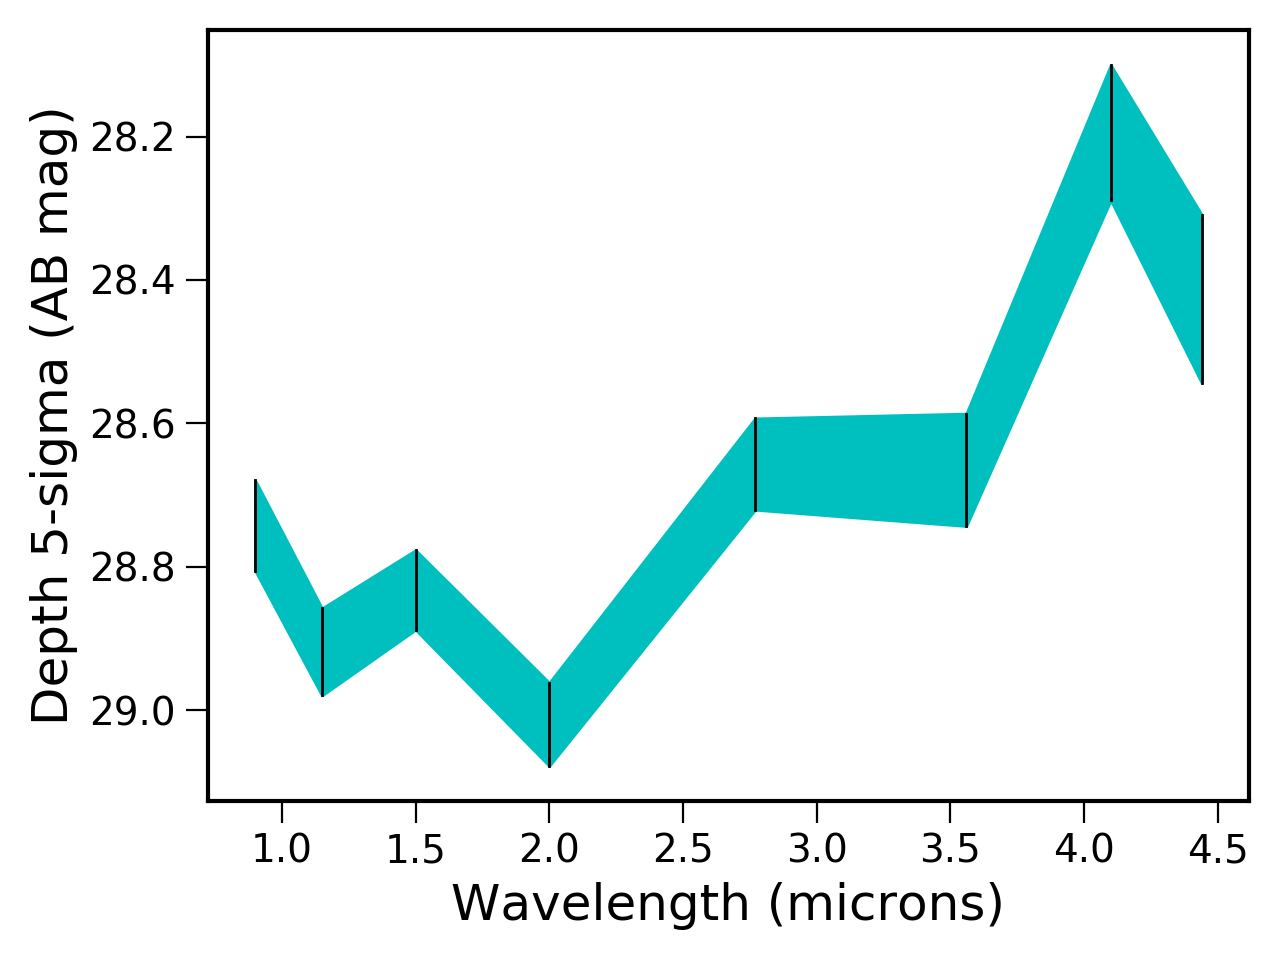

Text(0, 0.5, 'Depth 5-sigma (AB mag)')

In [24]:
# Plot depth in each filter
# Range is for minimum vs. maximum background

fig = plt.figure()

plt.fill_between(lams, lows, highs, color='c')

for i, filt in enumerate(filts):
    plt.plot([lams[i],lams[i]], depths[filt], color='k', lw=1)

plt.ylim(plt.ylim()[::-1])
plt.xlabel('Wavelength (microns)')
plt.ylabel('Depth 5-sigma (AB mag)')
#plt.title(target + ' depth')

<IPython.core.display.Javascript object>


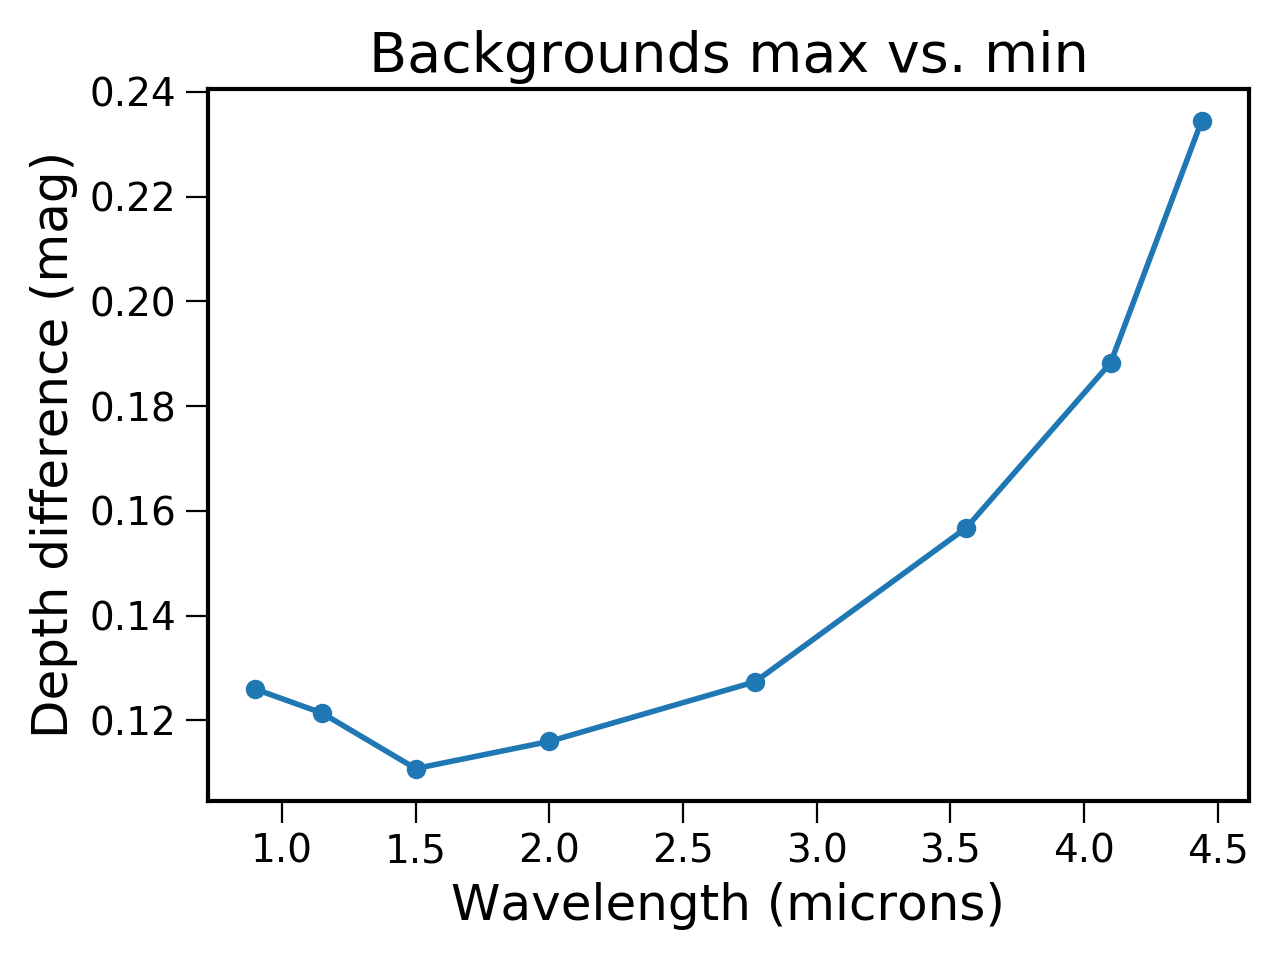

Text(0.5, 1.0, 'Backgrounds max vs. min')

In [15]:
# Plot variability of depth depending on background

fig = plt.figure()

plt.plot(lams, highs - lows, 'o-')

plt.xlabel('Wavelength (microns)')
plt.ylabel('Depth difference (mag)')
plt.title('Backgrounds max vs. min')

In [16]:
def calculate_SNR_variation_at_depth(filt, nexp, nint, ngroup, readmode, depth_snr=5):
    mag_bkglo,    exptime = calculate_depth(filt, nexp, nint, ngroup, readmode, snr=depth_snr, background=[bkg_lams, bkglo])
    SNR_high_bkg, exptime = NIRCam_Imaging_SNR(filt, mag_bkglo, nexp, nint, ngroup, readmode, background=[bkg_lams, bkghi])
    SNR_low_bkg = 5
    X = (SNR_low_bkg - SNR_high_bkg) / SNR_low_bkg
    return X, SNR_low_bkg, SNR_high_bkg

In [17]:
for filt in np.sort(filts):
    for exposure in exposures:
        filt1, filt2, readmode, ngroup, nint = exposure.lower().split()
        if filt in (filt1, filt2):
            nint = int(nint)
            ngroup = int(ngroup)
            X, SNR_low_bkg, SNR_high_bkg = calculate_SNR_variation_at_depth(filt, nexp, nint, ngroup, readmode)
            print(filt, ' %5.2f  %5.2f  %4.1f%% difference' % (SNR_low_bkg, SNR_high_bkg, X*100))

f090w   5.00   4.68   6.3% difference
f115w   5.00   4.69   6.2% difference
f150w   5.00   4.72   5.7% difference
f200w   5.00   4.70   5.9% difference
f277w   5.00   4.67   6.7% difference
f356w   5.00   4.65   7.0% difference
f410m   5.00   4.63   7.4% difference
f444w   5.00   4.53   9.4% difference


In [18]:
def calculate_SNR_variation(filt, mag, nexp, nint, ngroup, readmode):
    SNR_low_bkg,  exptime = NIRCam_Imaging_SNR(filt, mag, nexp, nint, ngroup, readmode, background=[bkg_lams, bkglo])
    SNR_high_bkg, exptime = NIRCam_Imaging_SNR(filt, mag, nexp, nint, ngroup, readmode, background=[bkg_lams, bkghi])
    X = (SNR_low_bkg - SNR_high_bkg) / SNR_low_bkg
    return X, SNR_low_bkg, SNR_high_bkg

In [19]:
def calculate_SNR_variations(filts, mag, exposures):
    for filt in filts:
        for exposure in exposures:
            filt1, filt2, readmode, ngroup, nint = exposure.lower().split()
            if filt in (filt1, filt2):
                nint = int(nint)
                ngroup = int(ngroup)
                X, SNR_low_bkg, SNR_high_bkg = calculate_SNR_variation(filt, mag, nexp, nint, ngroup, readmode)
                print(filt, ' %5.2f  %5.2f  %4.1f%% difference' % (SNR_low_bkg, SNR_high_bkg, X*100))

In [20]:
calculate_SNR_variations(filts, 28, exposures)

f090w  10.19   9.57   6.1% difference
f115w  11.87  11.17   5.9% difference
f150w  10.92  10.34   5.3% difference
f200w  12.87  12.16   5.5% difference
f277w   9.52   8.90   6.5% difference
f356w   9.72   9.06   6.8% difference
f410m   6.48   6.00   7.3% difference
f444w   8.18   7.42   9.3% difference


In [23]:
calculate_SNR_variations(filts, 27, exposures)

f090w  23.97  22.68   5.4% difference
f115w  27.68  26.25   5.1% difference
f150w  25.41  24.23   4.6% difference
f200w  29.50  28.12   4.7% difference
f277w  22.78  21.42   6.0% difference
f356w  23.27  21.81   6.3% difference
f410m  15.77  14.68   7.0% difference
f444w  20.07  18.28   8.9% difference


In [22]:
calculate_SNR_variations(filts, 26, exposures)

f090w  52.59  50.37   4.2% difference
f115w  59.76  57.43   3.9% difference
f150w  54.67  52.77   3.5% difference
f200w  62.09  60.00   3.4% difference
f277w  51.54  49.00   4.9% difference
f356w  52.59  49.86   5.2% difference
f410m  36.87  34.61   6.1% difference
f444w  47.69  43.81   8.1% difference


In [21]:
calculate_SNR_variations(filts, 24, exposures)

f090w  184.18  181.56   1.4% difference
f115w  200.89  198.44   1.2% difference
f150w  183.93  181.95   1.1% difference
f200w  201.01  199.05   1.0% difference
f277w  194.72  190.95   1.9% difference
f356w  199.10  195.03   2.0% difference
f410m  156.08  151.42   3.0% difference
f444w  213.46  203.63   4.6% difference
